In [ ]:
# The execution time of this notebook is around 1 hour with a GPU T4 x2
#!pip install tensorflow==2.17.1 # or 2.16.1

### **Introduction**

This notebook cover the model construction and training of an image captioning model using Flickr8k dataset. The model implement Bahdanau Attention according to this structure:

>  The CNN Encoder extracts features from an input image and transforms them into a suitable embedding size.

>  The RNN Decoder uses the Bahdanau attention mechanism to focus on different parts of the image features at each time step, while generating a sequence of words (captions).

The subclassed **Model API** was chosen over the Sequential API because the Model subclassing approach offers the flexibility required for complex architectures like the one described.

The outline is:

1. Loading and processing captions
2. Loading and extracting image features
3. Data generator to prepare input X[i] and target Y[i]
4. Define and train model
5. Visualize model outputs
6. Model evaluation
7. Model conclusions




### **Environmnet**

In [1]:
!python --version

Python 3.10.14


In [1]:
import os, re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

tf.__version__

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


'2.16.1'

In [2]:
def show_image(path: str):
    try:
        plt.figure(figsize=(15, 15))
        plt.imshow(Image.open(path))
        plt.axis('off')
        plt.show()
    except:
        print("Image not found")

### **Download Dataset**

The dataset is downloaded from GitHub, first we get two .zip file and once extracted contains the images in .jpg format and captions in .txt files. For more details about the dataset, see the notebook 1.

In [5]:
import shutil, zipfile
import requests

# Define paths and URLs
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
captions_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
dataset_dir = "flickr8k_dataset"
captions_file = "Flickr8k.token.txt"

# Create Dataset Directory
os.makedirs(dataset_dir, exist_ok=True)

# Download and Extract Functions
def download_file(url, dest_path):
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    with open(dest_path, "wb") as file:
        shutil.copyfileobj(response.raw, file)
    print(f"File saved to {dest_path}")

def extract_zip(file_path, extract_to):
    print(f"Extracting {file_path}...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted to {extract_to}")

# Download images
images_zip_path = os.path.join(dataset_dir, "images.zip")
images_extract_path = os.path.join(dataset_dir, "Flicker8k_Dataset")

if not os.path.exists(images_extract_path):
    download_file(dataset_url, images_zip_path)
    extract_zip(os.path.join(dataset_dir, "images.zip"), dataset_dir)
else:
    print("Images already downloaded")

# Download captions
captions_txt_path = os.path.join(dataset_dir, captions_file)
if not os.path.exists(captions_txt_path):
    download_file(captions_url, os.path.join(dataset_dir, "captions.zip"))
    extract_zip(os.path.join(dataset_dir, "captions.zip"), dataset_dir)
else:
    print("Captions already downloaded")

File saved to flickr8k_dataset/images.zip
Extracting flickr8k_dataset/images.zip...
Extracted to flickr8k_dataset
File saved to flickr8k_dataset/captions.zip
Extracting flickr8k_dataset/captions.zip...
Extracted to flickr8k_dataset


### **Loading Dataset**

The original dataset suggests a default split for training, test and validation. The same split is kept here.

In [6]:
# Paths
dataset_dir = "flickr8k_dataset"

def load_text(filename):
    file = open(filename, 'r')
    text = file.read()
    text = text.split('\n')
    file.close()
    return text

train_imgs = load_text(os.path.join(dataset_dir, "Flickr_8k.trainImages.txt"))
test_imgs = load_text(os.path.join(dataset_dir, "Flickr_8k.testImages.txt"))
dev_imgs = load_text(os.path.join(dataset_dir, "Flickr_8k.devImages.txt"))

train_imgs = [x for x in train_imgs if x != '']
test_imgs = [x for x in test_imgs if x != '']
dev_imgs = [x for x in dev_imgs if x != '']

print("Number of images in training set: ", len(train_imgs))
print("Number of images in test set: ", len(test_imgs))
print("Number of images in dev set: ", len(dev_imgs))

Number of images in training set:  6000
Number of images in test set:  1000
Number of images in dev set:  1000


### **Training Data Pipeline**

We will build the pipeline for our deep learning architecture in four phases

#### **1. Caption Text Preprocessing**



This phase covers:

* Convert sentences into lowercase

* Remove special characters, numbers present in the text and extra spaces

* Remove words with length to focus on more meaningful, context-rich words

* Add a starting and an ending tag to each caption to helps the model understand where captions begin and end

* Converts words in the caption into numerical tokens using a predefined vocabulary

* Pads all captions to a uniform length to ensure that all captions in a batch have the same length

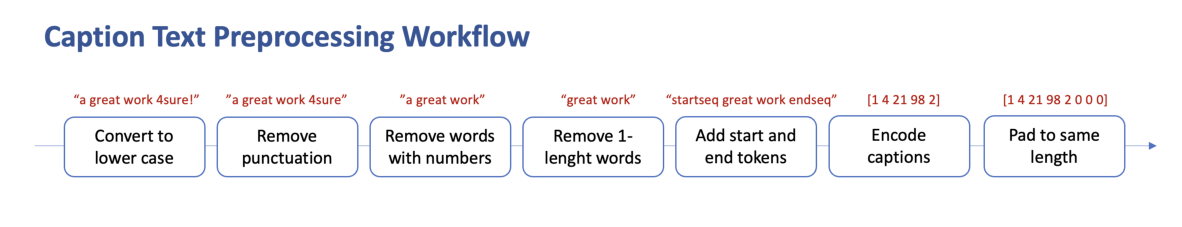

In [3]:
show_image("src/caption_preprocessing.png")

When loading the caption file, the captions are reorganized into a dictionary, where the image id serves as the key and a list of five captions corresponds to the value

In [8]:
# Load Captions
captions_file = "Flickr8k.token.txt"
captions_path = os.path.join(dataset_dir, captions_file)

def load_captions(filepath):
    captions = {}
    with open(filepath, 'r') as f:
        for line in f:
            image_id, caption = line.strip().split('\t')
            image_id = image_id.split('#')[0]
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
    return captions

captions_dictionary = load_captions(captions_path)
captions_dictionary['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
# Cleaning Captions

def clean_text(text):
    text = " ".join([word.lower() for word in text.split() if len(word) > 1])
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = "startseq " + text + " endseq"
    return text.lower()

for key, captions in captions_dictionary.items():
    for i, caption in enumerate(captions):
        captions[i] = clean_text(caption)

captions_dictionary['1000268201_693b08cb0e.jpg']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

For tokenizing captions and setting the vocabulary size, I rely on Keras's built-in tokenizer, which is easy and fast to use and integrates seamlessly with the Keras ecosystem. Pre-trained word embedding models such as GloVe, Word2Vec, or FastText can be used here to capture semantic meaning and relationships between words.

In [10]:
def flatten_captions (data_dict):
  return ([caption for key, captions in data_dict.items() for caption in captions])

def create_tokenizer(data_dict):
  captions = flatten_captions(data_dict)
  max_caption_words = max(len(caption.split()) for caption in captions)

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(captions)
  vocab_size = len(tokenizer.word_index) + 1

  return (tokenizer, vocab_size, max_caption_words)

In [11]:
# Fit a Keras tokenizer given caption descriptions
tokenizer, vocab_size, max_caption_words = create_tokenizer(captions_dictionary)

# Display first 10 words the results
print("Word Index (first 10 words):", dict(list(tokenizer.word_index.items())[:10]))
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_words)

Word Index (first 10 words): {'startseq': 1, 'endseq': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7, 'dog': 8, 'with': 9, 'man': 10}
Vocabulary Size: 8774
Maximum Caption Length: 34


#### **2. Images Preprocessing**



This phase cover the extraction of image feature maps using InceptionV3. The reason behind using InceptionV3 as the pre-trained CNN came from identify this model as popular for image captioning problems in the literature.



The convolutional layers in InceptionV3 produce compact, high-dimensional feature maps that summarize the image content. Another significant reason for using a pre-trained model is to reduce training time and improve generalization, as the model has already learned to extract meaningful features.

In [12]:
# list of images
def subset_image_name (filename):
  data = []
  with open(filename, "r") as fp:
    text = fp.read()
    lines = text.split ('\n')
    for line in lines:
      if (len(line) < 1):
        continue
      image_name = line.split ('.')[0]
      data.append (image_name)

    return (set(data))

training_image_name_file = "flickr8k_dataset/Flickr_8k.trainImages.txt"
training_image_names = subset_image_name (training_image_name_file)

To use InceptionV3, first let's prepare the images for input into the InceptionV3 model. Then, creates a new model that takes an image as input and outputs the feature map produced by the last convolutional layer.



I remove the classifier part (the fully connected layers) to isolate extracting features process.

In [13]:
# Preprocesses each image as input for InceptionV3 model
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) # default input size for InceptionV3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Load the InceptionV3 model without classification layer
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Create a new model that outputs feature maps from the convolutional base
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Instead of processing images through InceptionV3 repeatedly during captioning model training, the extracted features are precomputed and stored as .npy files. This idea was taken from liteature, claiming reduction in computation time and memory usage during training. The feature extraction pipeline overview is:



1. Image Paths → Create TensorFlow Dataset

2. Load and Preprocess Images → Using load_image

3. Extract Features → Using image_features_extract_model

4. Save Features → As .npy files for later use

In [14]:
from tqdm import tqdm
import numpy as np

image_dir = "flickr8k_dataset/Flicker8k_Dataset/"
training_image_paths = [image_dir + name + '.jpg' for name in training_image_names]
encode_train = sorted(set(training_image_paths))

# Create batch TensorFlow dataset
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Extract features over each dataset and saving
features_dir = "flickr8k_dataset/image_features"
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    os.makedirs(features_dir, exist_ok=True)
    base_name = os.path.basename(p.numpy().decode("utf-8"))
    path_of_feature = os.path.join(features_dir, base_name.replace(".jpg", ".npy"))
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [01:47<00:00,  3.50it/s]


 The .npy files  contain high-level feature maps, not human-readable images. These feature maps represent the abstract features extracted by the model, such as edges, textures, and object parts, which can be visualized as heatmaps or grids.

Feature map has a shape of (64, 2048), it represents 64 spatial locations (flattened grid of height × width) with 2048 channels. To visualize this data, we can reshape it into a 2D spatial grid if we know the dimensions of the feature map.



For InceptionV3, the last convolutional layer outputs a feature map with 8x8 dimension with 2048 channels, so the shape of the feature map for a single image is: (8, 8, 2048).

Feature Map Shape: (64, 2048)
Reshaped Feature Map Shape: (8, 8, 2048)


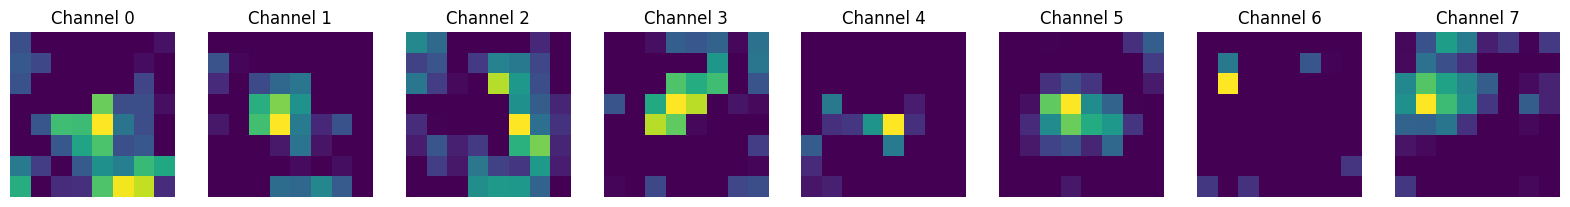

In [15]:
# Load the .npy file
feature_map = np.load("flickr8k_dataset/image_features/667626_18933d713e.npy")
reshaped_feature_map = feature_map.reshape((8, 8, 2048))
print("Feature Map Shape:", feature_map.shape)
print("Reshaped Feature Map Shape:", reshaped_feature_map.shape)

# Visualize multiple channels
num_channels_to_display = 8
fig, axes = plt.subplots(1, num_channels_to_display, figsize=(20, 5))

for i in range(num_channels_to_display):
    ax = axes[i]
    channel_data = reshaped_feature_map[:, :, i]
    channel_data_normalized = (channel_data - channel_data.min()) / (channel_data.max() - channel_data.min())
    ax.imshow(channel_data_normalized, cmap="viridis")
    ax.axis("off")
    ax.set_title(f"Channel {i}")

plt.show()

These feature maps show the activation patterns of individual filters (channels) in the last convolutional layer. Yellow areas in the feature maps indicate strong activations for that filter, meaning that the filter has identified a feature of interest in that region while dark purple areas represent low or no activations. These maps provide insights into the network's internal representation of the image, helping us understand what it "sees."

#### **3. Data Setup for Model Input**



Pre-processed captions and images is done, now let's setup the input data for the model as following:



* A train_X array consists of file paths

* A train_y array contains properly padded captions, ready for the model

* The tf.data.Dataset pipeline ensures efficient data loading, shuffling, batching, and prefetching

First, let's go through every training image and its matching captions to prepare the training data

In [16]:
# Returns the subset of the data dictionary given the image names
def subset_data_dict (captions_dictionary, image_names):
  dict = { image_name:captions for image_name, captions in captions_dictionary.items() if image_name in image_names}
  return (dict)

training_dict = subset_data_dict (captions_dictionary, train_imgs)
print("Number of images in training set: ", len(training_dict))

Number of images in training set:  6000


Now let's converts image paths (X) and padded captions (y) into NumPy arrays to align with your subsequent TensorFlow Dataset setup. As this function is very critical I decided to document it properly.

In [17]:
def data_prep(captions_dictionary, tokenizer, max_length, image_feature_dir):
    """
    Prepare the training data as NumPy arrays for TensorFlow Dataset.
    Args:
        captions_dictionary (dict): A dictionary where keys are image file names and values are lists of captions.
        tokenizer (Tokenizer): Tokenizer fitted on the captions.
        max_length (int): Maximum length for caption sequences (after padding).
        image_feature_dir (str): Directory path where the image files are stored.
    Returns:
        np.array, np.array: Arrays containing image paths and padded captions.
    """
    X, y = [], []

    for image_name, captions in captions_dictionary.items():
        image_path = f"{image_feature_dir}{image_name}"
        for caption in captions:
            word_idxs = tokenizer.texts_to_sequences([caption])[0]
            pad_idxs = pad_sequences([word_idxs], maxlen=max_length, padding='post')[0]
            X.append(image_path)
            y.append(pad_idxs)

    return np.array(X), np.array(y)

image_feature_dir = "flickr8k_dataset/image_features/"
train_X, train_y = data_prep(training_dict, tokenizer, max_caption_words, image_feature_dir)

print("Training data shapes:", train_X.shape, train_y.shape)
print(f"Example image path: {train_X[0].tolist()}")
print(f"Example caption sequence {train_y[0].tolist()}")


Training data shapes: (30000,) (30000, 34)
Example image path: flickr8k_dataset/image_features/1000268201_693b08cb0e.jpg
Example caption sequence [1, 41, 3, 89, 169, 6, 118, 52, 395, 11, 392, 3, 27, 5195, 692, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now let's create the Tensorflow datasets. The dataset loads the pre-processed encoded image vectors that were saved earlier

In [18]:
# Load preprocessed image features
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8').split('.')[0] + '.npy')
    return img_tensor, cap

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE) # load the numpy files in parallel

# Shuffle and batch the dataset
BATCH_SIZE = 64
BUFFER_SIZE = 1000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Example
for batch in dataset.take(1):
    img_tensors, captions = batch
    print("Image Tensor Shape:", img_tensors.shape)
    print("Captions Shape:", captions.shape)

Image Tensor Shape: (64, 64, 2048)
Captions Shape: (64, 34)


The Image Tensor Shape is: (64, 64, 2048), let's break it down:



* 64: Batch size

* 64: spatial resolution of the extracted feature maps

* 2048: The depth of the feature maps (channels)



And Caption Shape represents batch_size x max_caption_words

#### **4. Defining the Image Captioning Model**



The model is composed of four key components:



1. **Encoder**: The image encoding is pre-processed using a pre-trained Inception model, so the Encoder is relatively simple. It includes a Linear layer that processes the pre-encoded image features and forwards them to the Decoder.



2. **Sequence Decoder**: A recurrent neural network, implemented with LSTMs, serves as the Sequence Decoder. Before being input into this module, captions are passed through an Embedding layer.



3. **Attention Mechanism**: While the Decoder generates each word in the output sequence, the Attention module directs focus to the most relevant parts of the image to produce the appropriate word.



4. **Sentence Generator**: This component comprises a few Linear layers, which process the Decoder's output to compute a probability distribution over the vocabulary for each word position in the predicted caption.

This architecture involves technical challenges:



* Parallel branches:

    * The image encoder processes image features.

    * The decoder processes caption sequences.

* Attention mechanisms that dynamically compute weights based on interactions between encoder and decoder outputs.

* Handling complex input/output flows like multi-head attention, positional encoding, and sequence masking.



That's why I used **Functional API** (tf.keras.Model) due to it allows to create models that are non-linear or have complex architectures which suit the complex architectures  defined here.


In [19]:
import time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras import Model

# Encoder
class CNN_Encoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = Dense(embedding_dim)  # Fully connected layer to transform features

    def call(self, x):
        # x shape: (batch_size, attention_features_shape, features_shape)
        x = self.fc(x)  # shape: (batch_size, attention_features_shape, embedding_dim)
        x = tf.nn.relu(x)
        return x

# Attention Mechanism
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):

        # features shape: (batch_size, attention_features_shape, embedding_dim)
        # hidden shape: (batch_size, units)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)  # shape: (batch_size, 1, units)

        # Score computation
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # score shape: (batch_size, attention_features_shape, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # shape: (batch_size, attention_features_shape, 1)

        # Context vector computation
        context_vector = attention_weights * features  # shape: (batch_size, attention_features_shape, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # shape: (batch_size, embedding_dim)

        return context_vector, attention_weights

# Decoder
class RNN_Decoder(tf.keras.layers.Layer):

    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = Dense(units)
        self.fc2 = Dense(vocab_size)
        self.attention = BahdanauAttention(units)

    def call(self, x, features, hidden):

        # Attention mechanism
        context_vector, attention_weights = self.attention(features, hidden)

        # Embedding the input word
        x = self.embedding(x)  # x shape: (batch_size, 1, embedding_dim)

        # Concatenating the context vector and embedding
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)  # shape: (batch_size, 1, embedding_dim + embedding_dim)

        # Passing through the LSTM
        output, state_h, state_c = self.lstm(x)  # output shape: (batch_size, 1, units)

        # Passing through fully connected layers
        x = self.fc1(output)  # shape: (batch_size, 1, units)
        x = tf.reshape(x, (-1, x.shape[2]))  # shape: (batch_size, units)
        x = self.fc2(x)  # shape: (batch_size, vocab_size)

        return x, state_h, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

The choice of **Bahdanau Attention** in this model is driven by the literature in image captioning. Bahdanau Attention has been widely used and shown to perform well in sequence-to-sequence tasks, especially in neural machine translation and image captioning. Aditionaly, the additive attention mechanism helps models to focus on specific parts of the input sequence when generating each output element.



The same way define the architecture is a challenge, the training process demands a detaild re-construction of all the steps involved.

In [29]:
# Hyperparameters
embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(train_X) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

# Initialize Encoder and Decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# Optimizer and Loss Function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # Ignore padding tokens
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# Training Step
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)  # Teacher forcing

    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

# Training Loop
loss_plot = []
start_epoch = 0
EPOCHS = 30

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy()/int(target.shape[1]):.4f}')

    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.8132
Epoch 1 Batch 100 Loss 1.6120
Epoch 1 Batch 200 Loss 1.4398
Epoch 1 Batch 300 Loss 1.3234
Epoch 1 Batch 400 Loss 1.2363
Epoch 1 Loss 1.486836
Time taken for 1 epoch 122.58 sec

Epoch 2 Batch 0 Loss 1.3421
Epoch 2 Batch 100 Loss 1.2474
Epoch 2 Batch 200 Loss 1.2333
Epoch 2 Batch 300 Loss 1.0882
Epoch 2 Batch 400 Loss 1.0472
Epoch 2 Loss 1.145519
Time taken for 1 epoch 90.48 sec

Epoch 3 Batch 0 Loss 1.0867
Epoch 3 Batch 100 Loss 1.0830
Epoch 3 Batch 200 Loss 0.9912
Epoch 3 Batch 300 Loss 0.9987
Epoch 3 Batch 400 Loss 0.9605
Epoch 3 Loss 1.024468
Time taken for 1 epoch 90.01 sec

Epoch 4 Batch 0 Loss 1.0483
Epoch 4 Batch 100 Loss 0.8438
Epoch 4 Batch 200 Loss 0.9167
Epoch 4 Batch 300 Loss 0.9186
Epoch 4 Batch 400 Loss 0.9154
Epoch 4 Loss 0.944392
Time taken for 1 epoch 90.05 sec

Epoch 5 Batch 0 Loss 0.9456
Epoch 5 Batch 100 Loss 0.9139
Epoch 5 Batch 200 Loss 0.9057
Epoch 5 Batch 300 Loss 0.7557
Epoch 5 Batch 400 Loss 0.7718
Epoch 5 Loss 0.879684
Time taken fo

### **Visualization**



Ordinarily, as part of the training loop, the metrics are evaluated on the validation data. However, for academic purpose, after the model is trained I will inference only on the test data.

In [38]:
test_dict = subset_data_dict (captions_dictionary, test_imgs)
print("Number of images in test set: ", len(test_dict))

Number of images in test set:  1000


In [31]:
def evaluate(image, max_length):

    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot

def generate_caption(test_image_names, image_dict, image_dir, max_caption_words):
    
    # captions on the validation set
    rid = np.random.randint(0, len(test_image_names))
    image_name = test_image_names[rid] + '.jpg'
    real_caption = image_dict[image_name]
    real_caption = [caption.replace('startseq ', '').replace(' endseq', '') for caption in real_caption]

    image_path = image_dir + image_name
    result, attention_plot = evaluate(image_path, max_caption_words)
    generated_caption = ' '.join(result)

    # attention plot
    print(f"tokens generated: {len(result)}")
    attention_plot = attention_plot[:len(result), :] # remove the unused rows
    plt.imshow(attention_plot)
    plt.title("Attention Plot Concatenated")
    plt.axis('off')
    plt.show()

    return real_caption, generated_caption, attention_plot, image_path

The attention_plot visualizes the attention weights assigned to different regions of the image for each word in the generated caption.

Each cell in the heatmap corresponds to the attention weight assigned to a specific image region (X-axis) when generating a particular word (Y-axis). Brighter colors (higher intensity) indicate higher attention.

tokens generated: 6


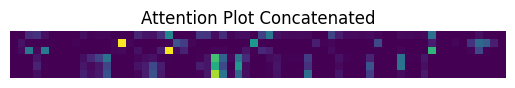

In [64]:
# Creating a random caption
image_dir = "flickr8k_dataset/Flicker8k_Dataset/"
test_image_name_file = "flickr8k_dataset/Flickr_8k.testImages.txt"
test_image_names = subset_image_name(test_image_name_file)

real_caption, generated_caption, attention_plot, image_path = generate_caption(list(test_image_names), test_dict, image_dir, max_caption_words)

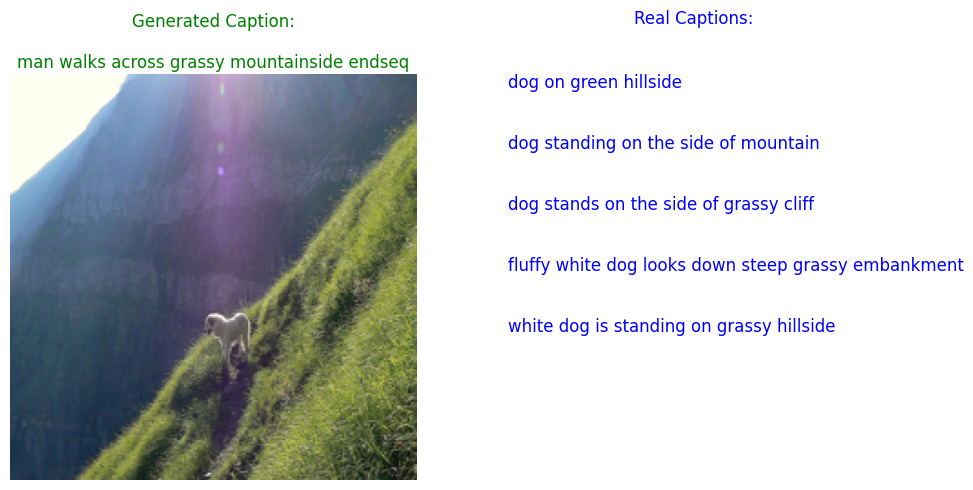

In [65]:
# Show captions and image
image_load = Image.open(image_path).resize((224, 224))
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(image_load)
ax1.set_title(f"Generated Caption:\n\n{generated_caption}", fontsize=12, color='green',  wrap=True)
ax1.axis("off")

ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.axis("off")
ax2.set_title("Real Captions:\n\n", fontsize=12, color='blue')

# Display each real caption as text
for j, caption in enumerate(real_caption):
    ax2.text(0.1, 1 - (j * 0.15), caption, fontsize=12, color='blue', wrap=True, ha='left', va='top')

plt.tight_layout()
plt.show()

Now let's overlay the attention weights on the original image for each word in the generated caption (the most popular image captioning plot) in a grid. Each subplot shows how the model's focus shifts across different regions of the image as it generates each word in the caption, where lighter regions indicate higher attention

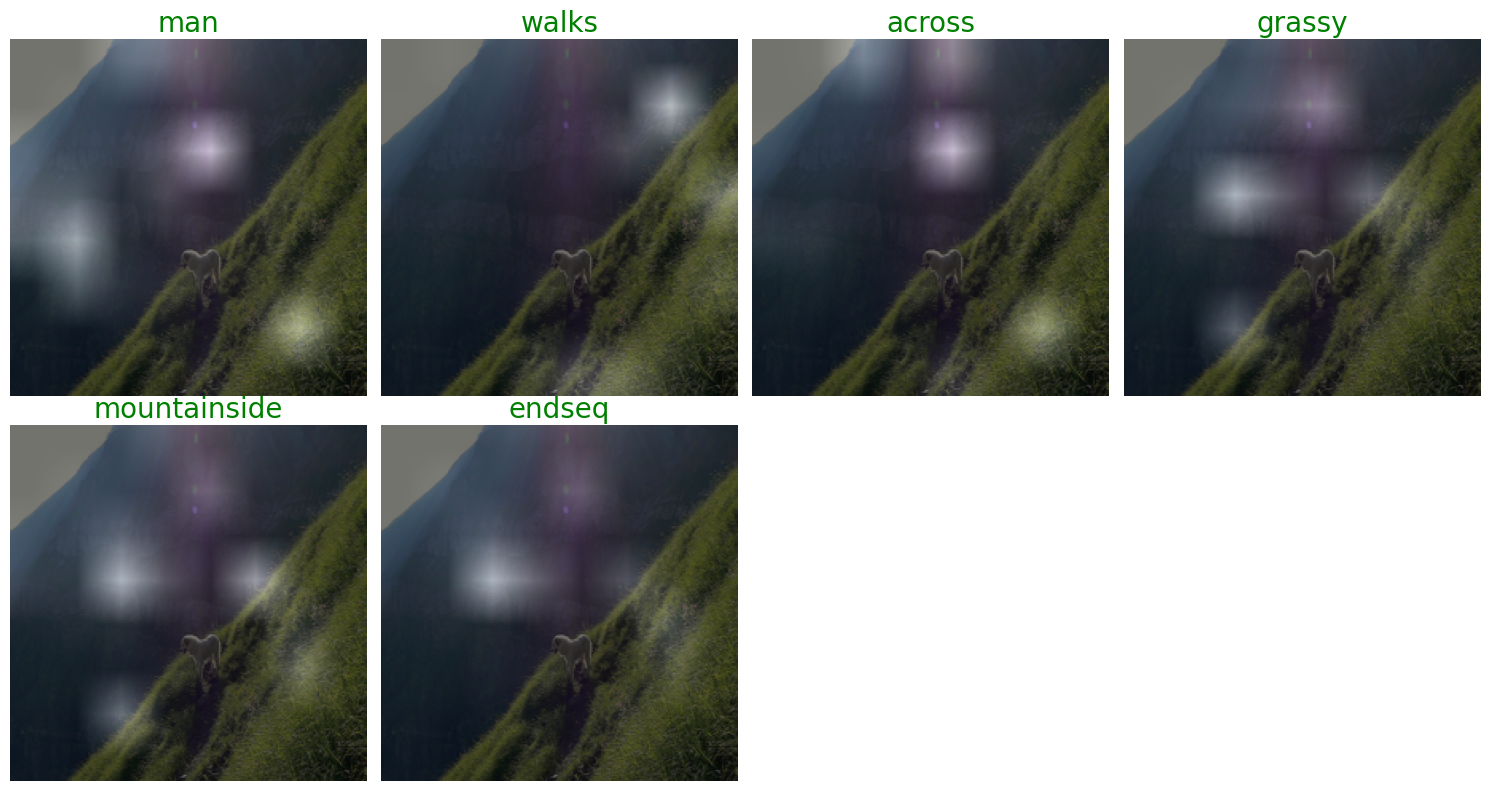

In [66]:
def plot_attention_grid(image_path, result, attention_plot, attention_features_shape=(8, 8)):
    """
    Display attention overlays for each word in the generated caption as a grid.

    Args:
        image_path (str): Path to the image file.
        result (list): Generated caption as a list of words.
        attention_plot (np.ndarray): Attention weights (shape: [len(result), attention_features_shape^2]).
        attention_features_shape (tuple): Shape of the attention feature map (default is 8x8).
    """
    image = Image.open(image_path).resize((224, 224))
    attention_plot = attention_plot[:len(result), :]
    attention_plot = np.reshape(attention_plot, (len(result), *attention_features_shape))

    # Define grid size
    num_words = len(result)
    grid_cols = 4
    grid_rows = (num_words + grid_cols - 1) // grid_cols  # Calculate rows dynamically

    # Create a figure for the grid
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, grid_rows * 4))
    axes = axes.flatten()

    for i, word in enumerate(result):
        temp_attention = attention_plot[i]
        attention_resized = np.array(Image.fromarray(temp_attention).resize((224, 224), Image.BILINEAR))
        attention_resized = attention_resized / np.max(attention_resized)

        axes[i].imshow(image)
        axes[i].imshow(attention_resized, cmap='gray', alpha=0.55)
        axes[i].set_title(word, fontsize=20, color='green')
        axes[i].axis("off")

    # Turn off unused subplots if the grid isn't full
    for j in range(len(result), len(axes)):
        axes[j].axis("off")

    # Adjust layout and show the grid
    plt.tight_layout()
    plt.show()

result = generated_caption.split()  # Convert generated caption to a list of words
plot_attention_grid(image_path, result, attention_plot)


### **Evaluation**

In [67]:
# Compute BLEU Scores for multiple test images

import warnings
warnings.filterwarnings("ignore")

num_images = 100
all_references = []
all_hypotheses = []

for img_name in test_imgs[:num_images]:

    # Actual captions
    img_path = os.path.join('flickr8k_dataset/Flicker8k_Dataset', img_name)
    actual_captions = test_dict.get(img_name, [])
    actual_captions = [caption.replace('startseq', '').replace('endseq', '').strip() for caption in actual_captions]
    actual_captions_tokens = [word_tokenize(caption.lower()) for caption in actual_captions]
    all_references.append(actual_captions_tokens)

    # Generate caption
    result, _ = evaluate(img_path, max_caption_words)
    generated_caption = ' '.join(result)
    generated_caption = generated_caption.replace('startseq', '').replace('endseq', '').strip()
    generated_caption_tokens = word_tokenize(generated_caption.lower())
    all_hypotheses.append(generated_caption_tokens)

# Compute corpus-level BLEU scores
from nltk.translate.bleu_score import corpus_bleu

bleu1 = corpus_bleu(all_references, all_hypotheses, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(all_references, all_hypotheses, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(all_references, all_hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(all_references, all_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

print(f"Corpus BLEU-1: {bleu1:.4f}")
print(f"Corpus BLEU-2: {bleu2:.4f}")
print(f"Corpus BLEU-3: {bleu3:.4f}")
print(f"Corpus BLEU-4: {bleu4:.4f}")

Corpus BLEU-1: 0.3383
Corpus BLEU-2: 0.1803
Corpus BLEU-3: 0.0954
Corpus BLEU-4: 0.0488


In [68]:
# Compute average sentence-level BLEU-1 score
bleu_scores = []
chencherry = SmoothingFunction()

for references, hypothesis in zip(all_references, all_hypotheses):
    score = sentence_bleu(
        references,
        hypothesis,
        weights=(1, 0, 0, 0),
        smoothing_function=chencherry.method1
    )
    bleu_scores.append(score)

average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average Sentence-Level BLEU-1 Score: {average_bleu:.4f}")


Average Sentence-Level BLEU-1 Score: 0.3538


In [69]:
# Compute average sentence-level BLEU-4 score
bleu_scores = []
chencherry = SmoothingFunction()

for references, hypothesis in zip(all_references, all_hypotheses):
    score = sentence_bleu(
        references,
        hypothesis,
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=chencherry.method1
    )
    bleu_scores.append(score)

average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average Sentence-Level BLEU-4 Score: {average_bleu:.4f}")

Average Sentence-Level BLEU-4 Score: 0.0700


### **Conclusion**

**Comparison with Base Line Model**
* BLEU-1: 0.3383 (baseline 0.3462)
    * Conclusion: the baseline model performs slightly better in unigram precision, indicating it captures individual relevant words more effectively. This might suggest that the simpler architecture is sufficient for detecting core keywords in image-caption pairs.

* BLEU-2: 0.1803 (baseline 0.1778)
    * Conclusion: the iterative model marginally improves bigram precision. This indicates that the complex model begins to better capture local context and word-to-word relationships compared to the baseline.


* BLEU-3: 0.0954 (baseline 0.0868)
    * Conclusion: the complex model shows a improvement in trigram precision. It suggests the iterative model can form longer, more coherent phrases, likely due to the inclusion of an attention mechanism that enhances context understanding.

* BLEU-4: 0.0488 (baseline 0.0296)
    * Conclusion: The iterative model significantly outperforms the baseline in BLEU-4, indicating it is better at generating fluent and syntactically correct sentences. This reflects the strength of the more sophisticated architecture in handling sentence-level coherence.

**Performance Analysis**

A BLEU-1 score of 33.83% indicates that the model captures some of the relevant words from the reference captions, but it is not perfect. This suggests that the model can identify key objects or entities in the image but may struggle with capturing the full context or correct grammatical structure.

Increasing the n-grams precision (BLUE-2/3/4) cause drops match. This indicates that while the model can occasionally pair words together in a meaningful sequence, it struggles to generate coherent and contextually accurate short phrases.

**Recommendations**

* To capture local relationships between objects and achieve a broader contextual understanding, a larger and more diverse dataset with high-quality captions can be used. This will help the model learn a richer vocabulary and better grasp grammatical structures.
* Additionally, experimenting with a transformer-based architecture can improve performance and accelerate the training process through parallelization.
* A promising approach is to use pretrained embeddings (e.g., GloVe, Word2Vec) to enhance the representation of words in captions.
* Finally, I recommend experimenting with hyperparameters such as learning rate, batch size, and embedding dimensions.

Current state-of-the-art models for image captioning achieve significantly higher BLEU scores and produce more fluent captions. Adopting components like others attention mechanisms, pretrained embeddings, or transformers could bridge the performance gap.